# 数据准备

In [1]:
# 数据处理
import numpy as np
import pandas as pd

# 读入数据集

df = pd.read_csv('./Telco-Customer-Churn.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
# 数据初步清洗
# 首先进行初步的数据清洗工作，包含错误值和异常值处理，并划分类别型和数值型字段类型，其中清洗部分包含：MultipleLines、OnlineSecurity、OnlineBackup、DeviceProtection、TechSupport、StreamingTV、StreamingMovies：错误值处理 TotalCharges：异常值处理 tenure：自定义分箱
# 错误值处理,这里不感兴趣直接被处理成了No
repl_columns = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies']
for i in repl_columns:
    df[i] = df[i].replace({ 'No internet service': 'No'})
df['MultipleLines'] = df['MultipleLines'].replace({'No phone service': 'No'})

# 替换值SeniorCitizen
df["SeniorCitizen"] = df["SeniorCitizen"].replace({1: "Yes", 0: "No"}) 

# 替换值TotalCharges
df[ 'TotalCharges'] = df[ 'TotalCharges'].replace( ' ', np.nan)
# TotalCharges空值：数据量小，直接删除
df = df.dropna(subset=[ 'TotalCharges'])
df.reset_index(drop= True, inplace= True) # 重置索引

<Axes: >

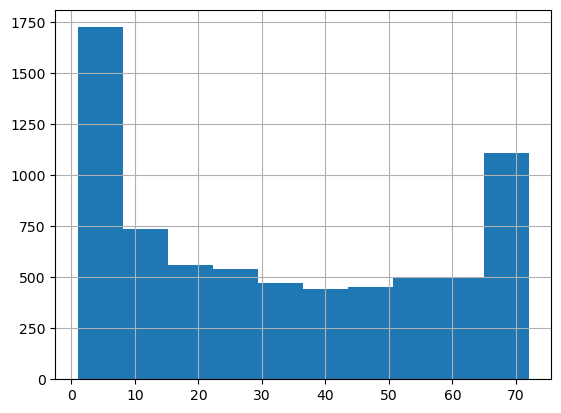

In [3]:
# improve explore
# 绘制直方图
df['tenure'].hist()

In [4]:
# 转换数据类型

"""
TODO 这里可以用聚类来进行分裂点划分，或者用学习什么的都行，是一个可以改良的点
"""

df[ 'TotalCharges'] = df[ 'TotalCharges'].astype( 'float')

# 转换tenure
def transform_tenure(x):
    if x <= 12:
        return('Tenure_1')
    elif x <= 24:
        return('Tenure_2')
    elif x <= 36:
        return('Tenure_3')
    elif x <= 48:
        return('Tenure_4')
    elif x <= 60:
        return('Tenure_5')
    else:
        return('Tenure_over_5')
df['tenure_group'] = df.tenure.apply(transform_tenure)

# 数值型和类别型字段
Id_col = ['customerID']

target_col = ['Churn']

cat_cols = df.nunique()[df.nunique() < 10].index.tolist()

num_cols = [i for i in df.columns if i not in cat_cols + Id_col]

print( '类别型字段：n', cat_cols)

print( '-' * 30)

print( '数值型字段：n', num_cols)

类别型字段：n ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn', 'tenure_group']
------------------------------
数值型字段：n ['tenure', 'MonthlyCharges', 'TotalCharges']


In [5]:
#探索性分析，目的是找到最有影响力的几个特征
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

#目标变量Churn分布
df['Churn'].value_counts()

trace0 = go.Pie(labels=['未流失客户','流失客户'],
#                 labels=df['Churn'].value_counts().index, 
                values=df['Churn'].value_counts().values,
                hole=.5,
                rotation=90,
                marker=dict(colors=['rgb(154,203,228)', 'rgb(191,76,81)'], 
                            line=dict(color='white', width=1.3))
               )
data = [trace0] 
layout = go.Layout(title='目标变量Churn分布', font=dict(size=26))

fig = go.Figure(data=data, layout=layout)
py.offline.plot(fig, filename= '整体流失情况分布.html', auto_open=False)

KeyboardInterrupt: 

In [ ]:
def plot_bar(input_col: str, target_col: str, title_name: str):
    cross_table = round(pd.crosstab(df[input_col], df[target_col], normalize='index')*100, 2)

    # 索引
    index_0 = cross_table.columns.tolist()[0] 
    index_1 = cross_table.columns.tolist()[1] 

    # 绘图轨迹
    trace0 = go.Bar(x=cross_table.index.tolist(), 
                    y=cross_table[index_0].values.tolist(), 
#                     name=index_0,
                    marker=dict(color='rgb(154,203,228)'),
                    name='未流失客户'
                   ) 
    trace1 = go.Bar(x=cross_table.index.tolist(), 
                    y=cross_table[index_1].values.tolist(), 
#                     name=index_1,
                    marker=dict(color='rgb(191,76,81)'),
                    name='流失客户'
                   ) 

    data = [trace0, trace1] 
    # 布局
    layout = go.Layout(title=title_name, bargap=0.4, barmode='stack', font=dict(size=26))
    
    # 画布
    fig = go.Figure(data=data, layout=layout)
    # 绘图
    py.offline.plot(fig, filename=f'./html/category_relation/{title_name}.html',auto_open=False) 

# 绘制数值型的数据在不同分布区间内流失和未流失客户的直方图可视化
def plot_histogram(input_col: str, title_name: str):
    churn_num = df[df['Churn'] == 'Yes'][input_col]
    not_churn_num = df[df['Churn'] == 'No'][input_col] 
    
    # 图形轨迹
    trace0 = go.Histogram(x=churn_num, 
                          bingroup=25,
                          histnorm='percent',
                          name='流失客户',
                          marker=dict(color='rgb(191,76,81)')
                         )
    trace1 = go.Histogram(x=not_churn_num, 
                          bingroup=25,
                          histnorm='percent',
                          name='未流失客户',
                          marker=dict(color='rgb(154,203,228)')
                         )

    data = [trace0, trace1]
    layout = go.Layout(title=title_name, font=dict(size=26))

    fig = go.Figure(data=data, layout=layout)
    py.offline.plot(fig, filename=f'./html/num_relation/{title_name}.html',auto_open=False) 

In [ ]:
#类别型数据与是否流失的关系
for char in cat_cols:
    plot_bar(input_col=char, target_col='Churn', title_name='{}与是否流失的关系'.format(char))
#数值类数据与是否流失的关系
for char in num_cols :
    plot_histogram(input_col=char, title_name='{}与是否流失的关系'.format(char))

In [ ]:
# #探索数值型变量相关性
# #中文显示问题
import matplotlib
# matplotlib.rc("font",family='SimHei')

# plt.figure(figsize=(8, 6))  
# sns.heatmap(df.corr(), linewidths=0.1, cmap='tab20c_r', annot=True)
# plt.title('数值型属性的相关性', fontdict={'fontsize': 'xx-large', 'fontweight':'heavy'}) 
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.show() 

In [ ]:
# 对于二分类变量，编码为0和1;
# 对于多分类变量，进行one_hot编码；
# 对于数值型变量，部分模型如KNN、神经网络、Logistic需要进行标准化处理。
# 建模数据
from sklearn.preprocessing import LabelEncoder
df_model = df
Id_col = ['customerID']
target_col = ['Churn']
# 分类型
cat_cols = df_model.nunique()[df_model.nunique() < 10].index.tolist()
# 二分类属性
binary_cols = df_model.nunique()[df_model.nunique() == 2].index.tolist()
# 多分类属性
multi_cols = [i for i in cat_cols if i not in binary_cols]
# 数值型
num_cols = [i for i in df_model.columns if i not in cat_cols + Id_col]
# 二分类-标签编码
le = LabelEncoder()
for i in binary_cols:
    df_model[i] = le.fit_transform(df_model[i])
# 多分类-哑变量转换
df_model = pd.get_dummies(data=df_model, columns=multi_cols)
df_model.head()
# 这里的tenure作为分组和本身的数值同时出现在了原本的数据输入中这合适吗，不应该吧数值类型的给down掉吗

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_Tenure_1,tenure_group_Tenure_2,tenure_group_Tenure_3,tenure_group_Tenure_4,tenure_group_Tenure_5,tenure_group_Tenure_over_5
0,7590-VHVEG,0,0,1,0,1,0,0,0,1,...,False,False,True,False,True,False,False,False,False,False
1,5575-GNVDE,1,0,0,0,34,1,0,1,0,...,False,False,False,True,False,False,True,False,False,False
2,3668-QPYBK,1,0,0,0,2,1,0,1,1,...,False,False,False,True,True,False,False,False,False,False
3,7795-CFOCW,1,0,0,0,45,0,0,1,0,...,True,False,False,False,False,False,False,True,False,False
4,9237-HQITU,0,0,0,0,2,1,0,0,0,...,False,False,True,False,True,False,False,False,False,False


改进思路材料

scikit-learn库中提供了一些常用的特征选择函数，包括：

f_classif（适用于分类问题的Fisher准则）：该函数适用于分类问题，它计算每个特征与类标签之间的相关系数，然后根据这些相关系数进行排序。Fisher准则是一种常见的特征选择方法，它认为与类标签相关的特征应该是重要的，因此选择前k个最佳的特征。
f_regression（适用于回归问题的Fisher准则）：该函数适用于回归问题，它计算每个特征与预测目标之间的相关系数，然后根据这些相关系数进行排序。与f_classif类似，f_regression也认为与预测目标相关的特征应该是重要的，因此选择前k个最佳的特征。
mutual_info_classif（基于互信息的选择）：该函数使用互信息（mutual information）来衡量特征与类标签之间的相关性。互信息是一种衡量两个变量之间相关性的指标，它反映了两个变量之间的信息共享程度。选择前k个最佳的特征。
mutual_info_regression（基于互信息的选择）：该函数使用互信息来衡量特征与预测目标之间的相关性。与mutual_info_classif类似，mutual_info_regression也基于互信息来选择前k个最佳的特征。
chi2（卡方检验）：该函数使用卡方检验（Chi-squared test）来衡量特征与类标签之间的相关性。卡方检验是一种常见的统计方法，它用于检验两个变量之间的独立性。选择前k个最佳的特征。
这些函数都有不同的特征，适用于不同的数据类型和问题。在使用SelectKBest类时，我们可以根据实际需求选择合适的函数来对特征进行排序和筛选。

In [ ]:
# 使用统计检定方式进行特征筛选。
#from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X = df_model.copy().drop(['customerID','Churn'], axis=1)
print(X.shape)
y = df_model[target_col]

# Hyper factor k=20 改变这个更换使用的特征数量，这里有可能会将哑变量给部分抽取，这样会导致模型的效果不好,带改良

fs = SelectKBest(score_func=f_classif, k=20) #卡方检验的方式进行排序筛选特征,但此时是有哑变量的，所以事实上不是综述只有20,而是32列，前20个特征这里确实是提取了
X_train_fs = fs.fit_transform(X,y)

print(X_train_fs.shape)

def SelectName(feature_data, model):
    scores = model.scores_
    indices = np.argsort(scores)[::-1]
    return list(feature_data.columns.values[indices[0:model.k]])

# 输出选择变量名称
SelectName(X, fs)
fea_name = [i for i in X.columns if i in SelectName(X,fs)]
X_train = pd.DataFrame(X_train_fs,columns = fea_name)
X_train.head()


(7032, 32)
(7032, 20)


e:\VirtualSpace\python_env\conda\data_analysis\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,TechSupport,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,tenure_group_Tenure_1,tenure_group_Tenure_over_5
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,29.85,29.85,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,0.0,34.0,1.0,0.0,0.0,56.95,1889.50,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,2.0,1.0,0.0,1.0,53.85,108.15,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,45.0,1.0,1.0,0.0,42.30,1840.75,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,2.0,0.0,0.0,1.0,70.70,151.65,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


观察特征提取的结果，我们会发现，tenure被使用了两次，也就是最终的模型被用了两次，但是好在没有出现哑变量被部分截取的情况

In [ ]:
# 模型建立和评估
# 首先使用分层抽样的方式将数据划分训练集和测试集。
# 重新划分
# 分层抽样
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.2, random_state=0, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#修正索引
for i in[X_train, X_test, y_train, y_test]:

    i.index = range(i.shape[0])

# 保存标准化训练和测试数据
st= StandardScaler()
# 先计算出标准化的新的数值型数据
num_scaled_train= pd.DataFrame(st.fit_transform(X_train[num_cols]), columns=num_cols)
num_scaled_test= pd.DataFrame(st.transform(X_test[num_cols]), columns=num_cols)
# 然后将这部分数据替换掉之前的为标准化的数据
X_train_scaled= pd.concat([X_train.drop(num_cols, axis= 1), num_scaled_train], axis= 1)
X_test_scaled= pd.concat([X_test.drop(num_cols, axis= 1), num_scaled_test], axis= 1)

(5625, 20) (1407, 20) (5625, 1) (1407, 1)


In [ ]:
# 建模
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 模型评估
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import recall_score, precision_score, f1_score, cohen_kappa_score

# 训练模型并且输出模型的各个结果指标函数
def model_report(model, X, y, name) :
    # model.fit(X_train, y_train) # 训练模型
    # y_pred  = model.predict(X_test) # 用模型预测一下y值
    # y_score = model.predict_proba(X_test)[:,1] # 找出了所有预测为1的结果的数量
    
    # 评估指标
    """
    这些是原本的方法，没有使用10折交叉检验
    accuracy = accuracy_score(y_test, y_pred)
    recallscore = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_score) # 计算roc分数
    f1score = f1_score(y_test, y_pred) # 计算F1值
    kappa_metric = cohen_kappa_score(y_test, y_pred)
    """
    # 使用5折交叉检验的版本
    accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean
    recallscore = cross_val_score(model, X, y, cv=5, scoring='recall').mean
    precision = cross_val_score(model, X, y, cv=5, scoring='precision').mean
    roc_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean
    f1score = cross_val_score(model, X, y, cv=5, scoring='f1').mean

    # 保存数据
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                    #    "Kappa_metric"    : [kappa_metric],
                      })
    return df

# 实例化模型
logit = LogisticRegression() 

knn = KNeighborsClassifier(n_neighbors=5) # knn的系数

svc_lin  = SVC(kernel='linear', random_state=0, probability=True) 

svc_rbf  = SVC(kernel='rbf', random_state=0, probability=True) 

mlp_model = MLPClassifier(hidden_layer_sizes=(8,), alpha=0.05, max_iter=50000, 
                          activation='logistic', random_state=0)

gnb = GaussianNB()

decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)  

rfc = RandomForestClassifier(n_estimators=100, random_state=0) 

lgbm_c = LGBMClassifier(boosting_type='gbdt', n_estimators=100, random_state=0) 

xgc = XGBClassifier(n_estimators=100, eta=0.02, max_depth=15, random_state=0, learning_rate=0.001)

model1 = model_report(logit, X, y,
                      "Logistic Regression")
model3 = model_report(svc_lin, X, y,
                      "SVM Classifier Linear")
model4 = model_report(svc_rbf, X, y,
                      "SVM Classifier RBF")
model5 = model_report(mlp_model, X, y,
                      "MLP Classifier")
model6 = model_report(gnb, X, y,
                      "Naive Bayes")
model7 = model_report(decision_tree, X, y,
                      "Decision Tree")
model8 = model_report(rfc, X, y,
                      "Random Forest Classifier")
model9 = model_report(lgbm_c, X, y,
                      "LGBM Classifier") 
model10 = model_report(xgc, X, y,
                      "XGBoost Classifier")

# 调用函数
# model1 = model_report(logit, X_train_scaled, X_test_scaled, y_train, y_test,
#                       "Logistic Regression")
# # model2 = model_report(knn, X_train_scaled, X_test_scaled, y_train, y_test,
# #                       "KNN Classifier")
# model3 = model_report(svc_lin, X_train_scaled, X_test_scaled, y_train, y_test,
#                       "SVM Classifier Linear")
# model4 = model_report(svc_rbf, X_train_scaled, X_test_scaled, y_train, y_test,
#                       "SVM Classifier RBF")
# model5 = model_report(mlp_model, X_train_scaled, X_test_scaled, y_train, y_test,
#                       "MLP Classifier")
# model6 = model_report(gnb, X_train, X_test, y_train, y_test,
#                       "Naive Bayes")
# model7 = model_report(decision_tree, X_train, X_test, y_train, y_test,
#                       "Decision Tree")
# model8 = model_report(rfc, X_train, X_test, y_train, y_test,
#                       "Random Forest Classifier")
# model9 = model_report(lgbm_c, X_train, X_test, y_train, y_test,
#                       "LGBM Classifier") 
# model10 = model_report(xgc, X_train, X_test, y_train, y_test,
#                       "XGBoost Classifier")

# 将结果绘制成表格
model_performances = pd.concat([model1,  model3,
                                model4, model5, model6,
                                model7, model8, model9, model10], axis=0).reset_index()

model_performances = model_performances.drop(columns="index",axis =1)

table  = ff.create_table(np.round(model_performances, 4))

py.offline.iplot(table) 

NameError: name 'X' is not defined

In [ ]:
# 我们也可以对模型进行进一步优化，比如对决策树参数进行调优。
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
parameters = { 'splitter': ( 'best', 'random'),
              'criterion': ( "gini", "entropy"),
              "max_depth": [* range( 3, 20)],
}

clf = DecisionTreeClassifier(random_state= 25)

GS = GridSearchCV(clf, parameters, scoring= 'f1', cv= 10)
GS.fit(X_train, y_train)
print(GS.best_params_)
print(GS.best_score_)
clf = GS.best_estimator_
test_pred = clf.predict(X_test)
print('测试集：n', classification_report(y_test, test_pred))

{'criterion': 'entropy', 'max_depth': 5, 'splitter': 'best'}
0.6014522720158608
测试集：n               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1033
           1       0.62      0.53      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.71      1407
weighted avg       0.78      0.79      0.78      1407



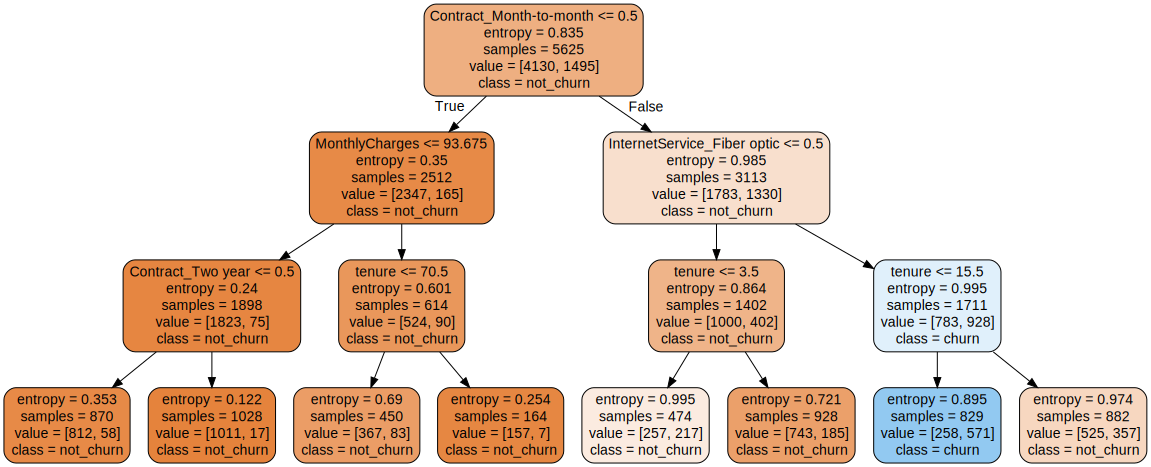

In [ ]:
#将这棵树画出来
import graphviz
# from pydotplus.graphviz import graph_from_dot_data
# from sklearn.tree import export_graphviz

part_DT = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
part_DT.fit(X_train, y_train)

dot_data = tree.export_graphviz(decision_tree=part_DT, max_depth=3,
                                 out_file=None, 
#                                  feature_names=X_train.columns,
                                 feature_names = X_train.columns,
                                 class_names=['not_churn', 'churn'], 
                                 filled=True,
                                 rounded=True
                                )
graphviz.Source(dot_data)
# graph = graphviz.Source(dot_data)
# graph
# graph = graph_from_dot_data(dot_data) # Create graph from dot data

# graph.write_png('./决策树.png') # Write graphto PNG image

In [ ]:
# 输出决策树属性重要性排序
import plotly.figure_factory as ff

import plotly as py

imp = pd.DataFrame(zip(X_train.columns, clf.feature_importances_))

imp.columns = ['feature', 'importances']

imp = imp.sort_values('importances', ascending=False)

imp = imp[imp['importances'] != 0]

table = ff.create_table(np.round(imp, 4))

py.offline.iplot(table)


e:\VirtualSpace\python_env\conda\data_analysis\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

e:\VirtualSpace\python_env\conda\data_analysis\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.8481254950277216
0.8307755822561357


e:\VirtualSpace\python_env\conda\data_analysis\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.7956616158740183


e:\VirtualSpace\python_env\conda\data_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.8475871119370919
0.8327608699028322
0.8285651055282626


e:\VirtualSpace\python_env\conda\data_analysis\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

e:\VirtualSpace\python_env\conda\data_analysis\lib\site-packages\sklearn\base.py:1151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.8241467404527594
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151
0.8412844060443856


e:\VirtualSpace\python_env\conda\data_analysis\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

e:\VirtualSpace\python_env\conda\data_analysis\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

e:\VirtualSpace\python_env\conda\data_analysis\lib\site-packages\xgboost\data.py:299: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

e:\VirtualSpace\python_env\conda\data_analysis\lib\site-packages\xgboost\data.py:301: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

e:\VirtualSpace\python_env\conda\da

0.8286712291182424


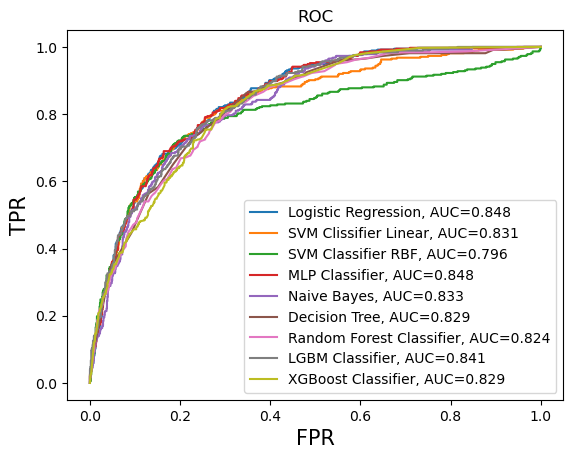

In [ ]:
#绘制ROC曲线
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

fprs = []
tprs = []
aucs=[]

def roc_img(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr,tpr)

    print(roc_auc)
    
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)

models = [logit,  svc_lin, svc_rbf, mlp_model, gnb, decision_tree, rfc, lgbm_c, xgc]
names = [ "Logistic Regression",   "SVM Clissifier Linear", 
         "SVM Classifier RBF","MLP Classifier", "Naive Bayes", "Decision Tree",
         "Random Forest Classifier", "LGBM Classifier", "XGBoost Classifier"]

for i in range(9):
    if i<5:
        roc_img(models[i], X_train_scaled, X_test_scaled, y_train, y_test, names[i])
    else:
        roc_img(models[i], X_train, X_test, y_train, y_test, names[i])
    plt.plot(fprs[i],tprs[i], lw=1.5, label="%s, AUC=%.3f"%(names[i],aucs[i]))
    
plt.xlabel("FPR",fontsize=15)
plt.ylabel("TPR",fontsize=15)

plt.title("ROC")
plt.legend(loc="lower right")
plt.show()

# 使用神经网络来完成这个任务

不需要再做单独的数据特征提取了，只需要将预处理好的所有特征都输入到网络中，然后让网络直接给出结果即可

In [ ]:
# 定义数据集
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# 步骤1：准备数据集
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y


X_data = df_model.drop(columns=["customerID", "Churn"])
X_label = df_model["Churn"]

X_data_norm = pd.DataFrame(st.fit_transform(X_data[num_cols]), columns=num_cols)
X_data_norm = pd.concat([X_data.drop(num_cols, axis= 1), X_data_norm], axis= 1)

import random

# 假设 data 是你的数据集，labels 是对应的标签
data = X_data_norm.values.astype(float)  # numpy强制类型转换
labels = X_label.values.astype(int)
# 将数据类型统一
print(type(data))
data = torch.from_numpy(data).float()
labels = torch.from_numpy(labels).long()

# 首先，确保 data 和 labels 一一对应

# 随机打乱数据集
random.seed(42)  # 设置随机种子以确保可重复性
print(len(data))
shuffled_indices = list(range(len(data)))
random.shuffle(shuffled_indices)

shuffled_data = []
shuffled_labels = []

for i in range(len(data)):
    shuffled_data.append(data[shuffled_indices[i]])
    shuffled_labels.append(labels[shuffled_indices[i]])

# 划分数据集
total_samples = len(shuffled_data)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_split = int(total_samples * train_ratio)
val_split = train_split + int(total_samples * val_ratio)

train_data = shuffled_data[:train_split]
train_labels = shuffled_labels[:train_split]

val_data = shuffled_data[train_split:val_split]
val_labels = shuffled_labels[train_split:val_split]

test_data = shuffled_data[val_split:]
test_labels = shuffled_labels[val_split:]

# 创建一个CustomDataset实例来表示训练数据集
train_dataset = CustomDataset(train_data, train_labels)
valid_dataset = CustomDataset(val_data, val_labels)
test_dataset = CustomDataset(test_data, test_labels)

# 步骤2：创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)
valid_loader = DataLoader(valid_dataset, batch_size=64)


<class 'numpy.ndarray'>
7032


In [ ]:
# 步骤3：定义模型
class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, int(hidden_size / 2))
        self.fc3 = nn.Linear(int(hidden_size / 2), int(hidden_size / 4))
        self.fc4 = nn.Linear(int(hidden_size / 4), num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        # x = self.relu(x)
        # x = self.fc4(x)
        return x

model = SimpleModel(input_size=32, hidden_size=100, num_classes=2)

# 步骤4：定义损失函数
criterion = nn.CrossEntropyLoss()

# 步骤5：选择优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 步骤6：训练模型
num_epochs = 1000
last_f1 = 0.0

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    correct = 0
    total = 0

    real_one = 0
    pre_one_true = 0 
    pre_one_false = 0
    pre_zero_true = 0
    pre_zero_false = 0

    # 使用f1值作为过拟合点判断
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model.forward(inputs)
            _, predicted = torch.max(outputs, 1)
            for pre in predicted:
                if pre == 1:
                    pre_one_false += (labels != predicted).sum().item()
                    pre_one_true += (labels == predicted).sum().item()
                else:
                    pre_zero_false += (labels != predicted).sum().item()
                    pre_zero_true += (labels == predicted).sum().item()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    recall = pre_one_true / (pre_one_true + pre_zero_false)
    precision = pre_one_true / (pre_one_true + pre_one_false)
    f1_score = 2 * precision * recall / (precision + recall)
    if last_f1 > f1_score:
        torch.save(model.state_dict(), 'model.pkl')
        print(f'last epoch : {epoch}, Accuracy on the valid set: {100 * accuracy:.2f}%')
        print(f'Accuracy on the test set: {100 * accuracy:.2f}%')
        print(f'Recall on the test set: {100 * recall:.2f}%')
        print(f'Precision on the test set: {100 * precision:.2f}%')
        print(f'F1-score on the test set: {100 * f1_score:.2f}%')
        break
    last_f1 = f1_score
    print(f'epoch : {epoch}')
    print(f'Accuracy set: {100 * accuracy:.2f}%')
    print(f'Recall set: {100 * recall:.2f}%')
    print(f'Precision set: {100 * precision:.2f}%')
    print(f'F1-score set: {100 * f1_score:.2f}%')

print("-"*10)
    # 使用准确值作为过拟合点的判断
    # with torch.no_grad():
    #     for inputs, labels in valid_loader:
    #         outputs = model.forward(inputs)
    #         _, predicted = torch.max(outputs, 1)
    #         total += labels.size(0)
    #         correct += (predicted == labels).sum().item()

    # accuracy = correct / total
    # if last_accuracy > accuracy:
    #     torch.save(model.state_dict(), 'model.pkl')
    #     print(f'last epoch : {epoch}, Accuracy on the valid set: {100 * accuracy:.2f}%')
    #     break
    # last_accuracy = accuracy
    # print(f'epoch : {epoch}, Accuracy on the valid set: {100 * accuracy:.2f}%')

# 步骤7：评估模型
# 我们认为1是流失了，就是检测出来的一个用户，这个看成正例

real_one = 0
pre_one_true = 0 
pre_one_false = 0
pre_zero_true = 0
pre_zero_false = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model.forward(inputs)
        _, predicted = torch.max(outputs, 1)
        for pre in predicted:
            if pre == 1:
                pre_one_false += (labels != predicted).sum().item()
                pre_one_true += (labels == predicted).sum().item()
            else:
                pre_zero_false += (labels != predicted).sum().item()
                pre_zero_true += (labels == predicted).sum().item()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
recall = pre_one_true / (pre_one_true + pre_zero_false)
precision = pre_one_true / (pre_one_true + pre_one_false)
f1_score = 2 * precision * recall / (precision + recall)
print(f'Accuracy on the test set: {100 * accuracy:.2f}%')
print(f'Recall on the test set: {100 * recall:.2f}%')
print(f'Precision on the test set: {100 * precision:.2f}%')
print(f'F1-score on the test set: {100 * f1_score:.2f}%')

epoch : 0
Accuracy set: 79.83%
Recall set: 40.32%
Precision set: 79.86%
F1-score set: 53.58%
epoch : 1
Accuracy set: 80.21%
Recall set: 53.12%
Precision set: 80.16%
F1-score set: 63.89%
last epoch : 2, Accuracy on the valid set: 81.44%
Accuracy on the test set: 81.44%
Recall on the test set: 49.12%
Precision on the test set: 81.62%
F1-score on the test set: 61.33%
----------
Accuracy on the test set: 81.44%
Recall on the test set: 49.12%
Precision on the test set: 81.62%
F1-score on the test set: 61.33%


通过使用神经网络，我搭建了一个简单的三层的网络结构，激活函数是relu，输入的是所有经过标准化和归一化处理的特征，而没有进行手动的特征筛选，在现有的数据集上进行了训练集-验证集-测试集的分割，并进行了模型训练和评估，最后得到了一个在测试集上的准确率为81.53%的模型，可以看到我们这个简单的神经网络模型的结果高出了之前所有的模型。

选择一个性能还不错的网络，我们想要输出他在第一层的线性函数参数，从而从中找到对结果贡献较大的特征，与传统的方法进行对比

In [ ]:
# 神经网络给出的重要性特征的探索
X_data_headers = X_data.columns.values.tolist()
print(X_data_headers)
# 根据权重参数进行排序，我们认为绝对值越的对于最终的结果影响越大，基于这个认知，我们进行下述操作
# 将每个特征对应的权重值进行求绝对值运算，然后将这个权重值进行累加，用这个累加后的结果参与排序，作为重要性指标
# 获取特征层的权重参数
feature_weight = model.state_dict()['fc1.weight']
abs_feature_weight = torch.abs(feature_weight)
sum_abs_feature_weight = list(abs_feature_weight.sum(dim=1))
print(sum_abs_feature_weight)


for i in range(len(X_data_headers)):
    for j in range(0, len(X_data_headers) - i - 1):
        if sum_abs_feature_weight[j] < sum_abs_feature_weight[j + 1]:
            X_data_headers[j], X_data_headers[j + 1] = X_data_headers[j + 1], X_data_headers[j]
            sum_abs_feature_weight[j], sum_abs_feature_weight[j + 1] = sum_abs_feature_weight[j + 1], sum_abs_feature_weight[j]

print(sum_abs_feature_weight)
for i in range(len(X_data_headers)):
    print(X_data_headers[i], sum_abs_feature_weight[i])

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'tenure_group_Tenure_1', 'tenure_group_Tenure_2', 'tenure_group_Tenure_3', 'tenure_group_Tenure_4', 'tenure_group_Tenure_5', 'tenure_group_Tenure_over_5']
[tensor(2.5085), tensor(3.0021), tensor(3.6075), tensor(2.9942), tensor(3.1955), tensor(3.1550), tensor(2.9383), tensor(3.9614), tensor(2.8122), tensor(2.9193), tensor(3.3020), tensor(2.6238), tensor(2.9674), tensor(3.3294), tensor(2.4104), tensor(2.9522), tensor(2.6725), tensor(3.1514), tensor(3.6

# Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
result = cross_val_score(model , X , y , cv=kfold)
mean_result = np.mean(result)




train_data = pd.read_csv("E:/competitions/kaggle/House Price/train.csv")
X = pd.DataFrame(train_data["GrLivArea"].fillna(0))
y = train_data["SalePrice"]
score = []
alphas = []
for alpha in range(1,100,1):
    alphas.append(alpha)
    rdg = KNeighborsRegressor(alpha)
    sc = np.sqrt( -cross_val_score(rdg,X,y,scoring = "neg_mean_squared_error", cv = 10))
    score.append(sc.mean())
plt.plot(alphas,score)
plt.show()


# k 折交叉验证（k-fold cross validation）

from sklearn.model_selection import cross_val_score

clf = svm.SVC(kernel='linear', C=1)

scores = cross_val_score(clf, iris.data, iris.target, cv=5)

print("scores:",scores)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print("\n")

# 集成不稳定的模型


# 进行上采样

# 特征提取优化 